## Importing the dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Import data into tensorflow dataset object

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50 

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


## Visualize some of the images from dataset

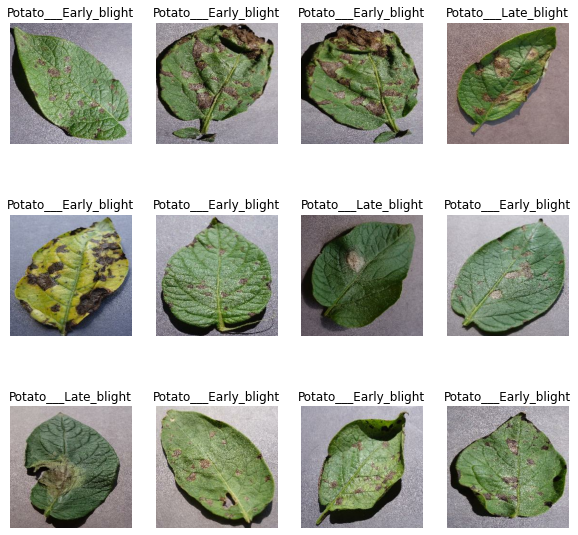

In [11]:
plt.figure(figsize= (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
     
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

## Splitting the dataset
Dataset should be divided into 3 sets: Training, Validation, Test

In [12]:
len(dataset)

68

In [13]:
train_size = 0.8
len(dataset)* train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    assert (train_split + test_split + val_split) == 1, "split values doesnt sum up to 1"
    ds_size = len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed= 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)  
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

54

In [24]:
len(val_ds)

6

## Cache, Shuffle, and Prefetch the Dataset

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Creating a Layer for Resizing and Normalization

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Building Model

In [43]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [44]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (32, 30, 30, 64)         

In [45]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=2,
)

Epoch 1/2
54/54 [==============================] - 162s 3s/step - loss: 0.8744 - accuracy: 0.5671 - val_loss: 0.7970 - val_accuracy: 0.6094
Epoch 2/2
54/54 [==============================] - 157s 3s/step - loss: 0.6589 - accuracy: 0.6829 - val_loss: 0.4767 - val_accuracy: 0.7500


In [48]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 664ms/step - loss: 0.4208 - accuracy: 0.8008


In [49]:
scores

[0.4208424687385559, 0.80078125]

###  Accuracy and Loss Curves Visualization 

In [50]:
history

In [52]:
history.params

{'verbose': 1, 'epochs': 2, 'steps': 54}

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
history.history['loss']

[0.8743656277656555, 0.658881425857544]

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

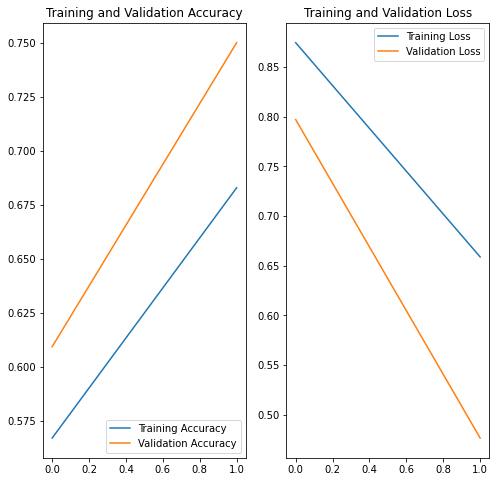

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(2), acc, label='Training Accuracy')
plt.plot(range(2), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(2), loss, label='Training Loss')
plt.plot(range(2), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on a sample image 

predict disease on a image
actual_label:  Potato___Early_blight
Potato___Early_blight


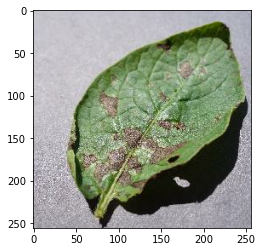

In [63]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("predict disease on a image")
    plt.imshow(first_image)
    print("actual_label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    predicted_label= class_names[np.argmax(batch_prediction[0])]
    print(predicted_label)

### predict on few more sample images 

In [64]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

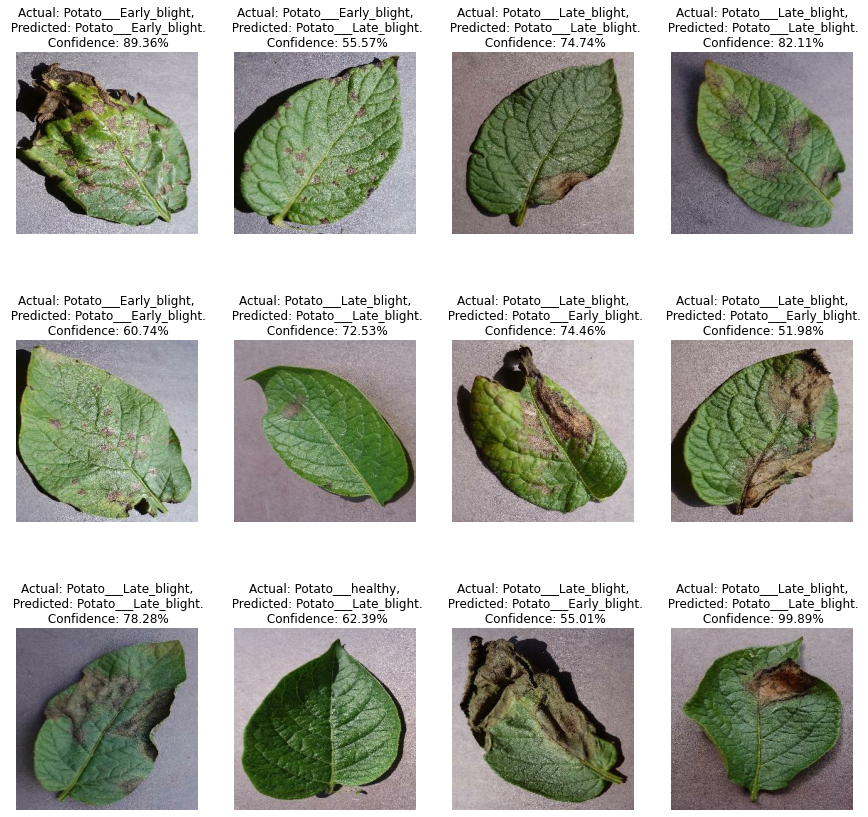

In [77]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [82]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/1\assets


In [83]:
model.save("../potatoes.h5")